This notebook will serve as a brief exploratory data analysis (EDA) of some of the NFL data publicly available at https://www.armchairanalysis.com/nfl-data.php . This data analysis was performed on Nov. 1, 2019 using the 2-week free dataset. The purpose of this EDA is to study interesting aspects of the data and open it up to be further studied as part of my capstone project, should I be accepted to The Data Incubator as a Fellow/Scholar.

Each entry in the data consists of a single play that was run in an NFL game (over the last two weeks, for the free data). Incredible attention to detail has been taken with this dataset, as it includes hundreds of variables for each play (see https://www.armchairanalysis.com/2019_AA_Table_Fields.pdf). Because the data is so well-cleaned, this will save me significant time in analyzing it (since we all know that 80% of the time spent analazying data is cleaning it), and I hope to discover meaningful results.

My goals for this EDA are to analyze certain aspects of the data, hopefully raising interesting questions that I would spend my capstone project attempting to answer. In this EDA, I will focus on 4th down plays, specifically these plays where teams choose to "go for it", trying to reach the first down instead of punting or kicking a field goal.

Due to the time limitations of The Data Incubator's challenge and the immense size of the dataset, I was unable to completely explore the data. I hope that what I show here in this EDA is sufficient evidence, however, that I am capable of analyzing this data, and that there are meaningful results to be found in this dataset.

Finally, though I am using the "free" version of this dataset (only the last 2 weeks are available), I would spend the $125 necessary to access the full research version of the dataset if I were accepted to The Data Incubator's fellowship program.

-----------------------------------------------------------------------
First, we begin by importing the necessary libraries and looking at the data files contained in the zip file available via the first link above.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
os.listdir('.')

['nfl_sample_data_research_2019.zip',
 '2019_AA_Table_Fields.pdf',
 'BLOCK.csv',
 'CONV.csv',
 'DEFENSE.csv',
 'DRIVE.csv',
 'FGXP.csv',
 'FUMBLE.csv',
 'GAME.csv',
 'INJURY.csv',
 'INTERCPT.csv',
 'KICKER.csv',
 'KOFF.csv',
 'OFFENSE.csv',
 'PASS.csv',
 'PBP.csv',
 'PENALTY.csv',
 'PLAY.csv',
 'PLAYER.csv',
 'PUNT.csv',
 'REDZONE.csv',
 'RUSH.csv',
 'SACK.csv',
 'SAFETY.csv',
 'SCHEDULE.csv',
 'SNAP.csv',
 'TACKLE.csv',
 'TD.csv',
 'TEAM.csv',
 '.ipynb_checkpoints',
 'nfl_eda.ipynb',
 'NFL_EDA.ipynb']

There are a TON of csv's in here! These files are explained in detail in https://www.armchairanalysis.com/2019_AA_Table_Fields.pdf . Here, since we want to analyze 4th down plays, we want the "PBP" file.

In [2]:
pbp = pd.read_csv('PBP.csv')
print(pbp.columns)

Index(['gid', 'pid', 'detail', 'off', 'def', 'type', 'dseq', 'len', 'qtr',
       'min', 'sec', 'ptso', 'ptsd', 'timo', 'timd', 'dwn', 'ytg', 'yfog',
       'zone', 'yds', 'succ', 'fd', 'sg', 'nh', 'pts', 'bc', 'kne', 'dir',
       'rtck1', 'rtck2', 'psr', 'comp', 'spk', 'loc', 'trg', 'dfb', 'ptck1',
       'ptck2', 'sk1', 'sk2', 'ptm1', 'pen1', 'desc1', 'cat1', 'pey1', 'act1',
       'ptm2', 'pen2', 'desc2', 'cat2', 'pey2', 'act2', 'ptm3', 'pen3',
       'desc3', 'cat3', 'pey3', 'act3', 'ints', 'iry', 'fum', 'frcv', 'fry',
       'forc', 'saf', 'blk', 'brcv', 'fgxp', 'fkicker', 'dist', 'good',
       'punter', 'pgro', 'pnet', 'ptb', 'pr', 'pry', 'pfc', 'kicker', 'kgro',
       'knet', 'ktb', 'kr', 'kry'],
      dtype='object')


Now, we want to select all 4th down plays where the offensive team "goes for it". We want those that (1) are 4th down, (2) did not end in a punt, and (3) did not end in a field goal.

In [3]:
mask = (pbp['dwn']==4) & (pbp['type'] != 'PUNT') & (pbp['type'] != 'FGXP')
fourth_down_attempts = pbp[mask]
print(len(fourth_down_attempts))

94


At first, it seems like we have 94 possible 4th down conversion attempts over 2 weeks. This seems like a lot! Let's look a bit further There are three "types" of plays remaining that may occur on a 4th down: RUSH, PASS, and NOPL (no play). There is actually a lot of information buried in these no-plays, so let's investigate them a bit more. We thought we eliminated all the punts and field goals, but let's see what's in these no-plays:

In [4]:
no_plays = fourth_down_attempts[fourth_down_attempts['type']=='NOPL']
print('Failed punts: %i' %(sum(['punt' in p.lower() for p in no_plays['detail']])))
print('Failed FGs: %i' %(sum(['field goal' in p.lower() for p in no_plays['detail']])))

Failed punts: 12
Failed FGs: 5


Any time a 4th down occurred and there was a penalty that negated the play, the result was NOPL, even if it was actually a punt or field goal attempt. Let's clean these out and look at the rest of our no-plays data.

In [5]:
msk1 = np.array(['punt' not in p.lower() for p in no_plays['detail']])
msk2 = np.array(['field goal' not in p.lower() for p in no_plays['detail']])
almost_plays = no_plays[(msk1) & (msk2)]
for d in almost_plays['detail']:
    print(d)

(:55) (Shotgun) PENALTY on GB-A.Rodgers, False Start, 5 yards, enforced at CHI 46 - No Play.
(4:38) (No Huddle) PENALTY on ARI-Z.Allen, Neutral Zone Infraction, 5 yards, enforced at ARI 19 - No Play.
(:05) (Shotgun) PENALTY on DET, Delay of Game, 5 yards, enforced at DET 15 - No Play.
(6:21) (Shotgun) J.Garoppolo sacked at TB 40 for -4 yards (J.Whitehead). PENALTY on TB-C.Davis, Defensive Holding, 5 yards, enforced at TB 36 - No Play.
(1:28) (Run formation) PENALTY on TB, Delay of Game, 1 yard, enforced at TB 3 - No Play.
(:03) (Shotgun) PENALTY on BAL, Delay of Game, 5 yards, enforced at ARI 5 - No Play.
(3:38) (No Huddle) PENALTY on TEN-M.Mariota, Delay of Game, 5 yards, enforced at TEN 34 - No Play.
(4:10) A.Dalton pass short left to T.Boyd for 16 yards, TOUCHDOWN NULLIFIED by Penalty. PENALTY on CIN-B.Price, Offensive Holding, 10 yards, enforced at SF 16 - No Play.
(12:50) (Shotgun) PENALTY on OAK-R.Grant, False Start, 5 yards, enforced at OAK 30 - No Play.
(:09) (Pass formation) P

It seems like these are all what we want. All the data are plays where the offense appears to be "going for it". Let's apply these filtering conditions to our data and continue

In [6]:
msk1 = np.array(['punt' not in p.lower() for p in fourth_down_attempts['detail']])
msk2 = np.array(['field goal' not in p.lower() for p in fourth_down_attempts['detail']])
fourth_down_attempts = fourth_down_attempts[(msk1) & (msk2)]
print(len(fourth_down_attempts))

76


We now have 76 4th down conversion attempts to work with. This will do for now, but we would like to have more data in the future.

Let's answer some basic questions about our data. What is the overall conversion rate on 4th down, when the play was truly executed (ignoring the NOPLs for now)?

In [7]:
conversion_rate = sum((fourth_down_attempts['type']!='NOPL') & (fourth_down_attempts['fd']=='Y'))/sum(fourth_down_attempts['type']!='NOPL')
print(conversion_rate)

0.5161290322580645


How does the conversion rate look for plays of different yardage? Say, 3 or less vs 4 or more?

In [8]:
msk_convert_3orless = (fourth_down_attempts['type']!='NOPL') & (fourth_down_attempts['ytg']<=3) & (fourth_down_attempts['fd']=='Y')
msk_3orless = (fourth_down_attempts['type']!='NOPL') & (fourth_down_attempts['ytg']<=3)
msk_convert_4ormore = (fourth_down_attempts['type']!='NOPL') & (fourth_down_attempts['ytg']>3) & (fourth_down_attempts['fd']=='Y')
msk_4ormore = (fourth_down_attempts['type']!='NOPL') & (fourth_down_attempts['ytg']>3)
print('Success rate with <= 3 ytg: %.2f' %(sum(msk_convert_3orless)/sum(msk_3orless)))
print('Success rate with > 3 ytg: %.2f' %(sum(msk_convert_4ormore)/sum(msk_4ormore)))

Success rate with <= 3 ytg: 0.51
Success rate with > 3 ytg: 0.52


It looks like there's no difference in the success rate of converting whether or not the team is in a 4th-and-short vs 4th-and-medium/long situation. That's pretty surprising!

Let's keep looking. What's the average score differential (offense points - defense points) when the team tries to convert a 4th down?

Average point differential: -8.36


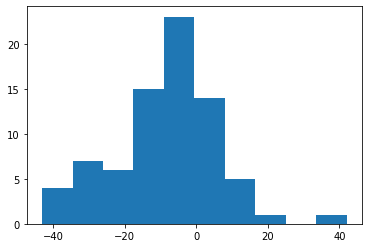

In [9]:
delta_points = np.array(fourth_down_attempts['ptso'])-np.array(fourth_down_attempts['ptsd'])
print('Average point differential: %.2f' %np.average(delta_points))
plt.hist(delta_points)
plt.show()

So 4th down conversion attempts mostly happen when the offense is losing. That makes sense, as the offense likely feels like they have extra motivation to score when they're down by so much, and a winning offense would rather take the advantageous field position for their defense, rather than potentially score more points.

How common are penalties on 4th down, and how does this compare to normal play?

In [13]:
n_penalties_4d = sum([str(p) != 'nan' for p in fourth_down_attempts['ptm1']])
n_penalties_global = sum([str(p) != 'nan' for p in pbp['ptm1']])
penalty_rate_4d = n_penalties_4d/len(fourth_down_attempts)
penalty_rate_global = n_penalties_global/len(pbp)
print('Global: %.2f        4th down only: %.2f' %(penalty_rate_global, penalty_rate_4d))

Global: 0.11        4th down only: 0.22


This is pretty interesting, too! It seems like penalties happen twice as frequently on 4th downs as on all other plays. Perhaps players get nervous when they know their team is trying to make/stop a 4th down conversion, and they make mental mistakes? This requires further study.

Next, what does the distribution look like for number of yards to go?

Average yards to go: 5.13
Median yards to go:  3.00


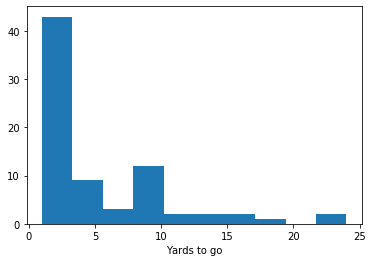

In [17]:
print('Average yards to go: %.2f' %np.average(fourth_down_attempts['ytg']))
print('Median yards to go:  %.2f' %np.median(fourth_down_attempts['ytg']))
plt.hist(fourth_down_attempts['ytg'])
plt.xlabel('Yards to go')
plt.show()

Looks like the data are heavily skewed towards shorter yards to go, with a long tail (and one sad attempt on 4th and 23) toward longer yards to go.

Next, what about play-calling? How frequently are rushing plays called, and how frequently are passing plays called?

In [14]:
n_rushes = sum(fourth_down_attempts['type']=='RUSH')
n_passes = sum(fourth_down_attempts['type']=='PASS')
print('Rush percentage: %.2f     Pass Percentage %.2f' %(n_rushes/(n_rushes+n_passes), n_passes/(n_rushes+n_passes)))

Rush percentage: 0.27     Pass Percentage 0.73


This is also pretty surprising! Since most attempts are made with only a few yards to go, it seems surprising that teams are more likely to try a risky pass play than a relatively safer rushing play. This certainly requires further study (though that is beyond the scope of this EDA).

Finally, let us look at field position. Where do teams often attempt 4th down conversions from on the field?

Average yards to opposing endzone: 39.84


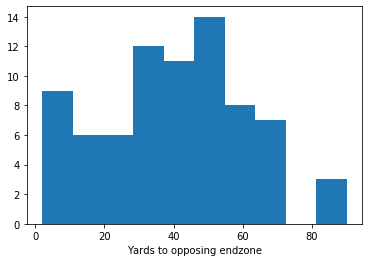

In [18]:
yardline = 100-np.array(fourth_down_attempts['yfog'])
print('Average yards to opposing endzone: %.2f' %np.average(yardline))
plt.hist(yardline)
plt.xlabel('Yards to opposing endzone')
plt.show()

So, we see a mostly normal distribution centered around midfield with a slight increase in attempts in near-endzone situations. With more data, these trends will certainly become clearer.

-------------------------------------------------------
Again, given the time constraints of The Data Incubator's challenge, I was unable to go as in-depth as I would like in this EDA. I believe that I have explored the data enough to raise interesting questions, and that I have demonstrated that I am capable of analyzing the data to answer these.

With more time (and more data), I would like to further study 4th downs. What are the expected points per attempt? How frequently do 4th down attempts/conversions result in points for the offense? What is the expected number of points for the opposing *defense* on 4th down attempts/conversions? Ultimately, when is it "worth it" to go for it on 4th down?

In addition to studying 4th down plays, I would like to answer many other common football questions using the beautiful dataset provided by Armchair Analysis. For example, conventional wisdom says that it's smart for defenses to blitz on 3rd downs, especially when the offense is led by an inexperienced quarterback. Is there truth to this? As another example, poor weather conditions often lead to conservative play-calling and more rushing plays than passing plays. Is this true, and if so, does it actually work for offenses playing in bad conditions?

Answers to these questions are just some of the possible results I would produce, if I were selected for The Data Incubator's Fellowship program.